# I. Introduction <p>
Songs have become essential to many people’s lives. This project used the existing data set to train and test and give the prediction of the next popular song. Which song could become a smash hit in the future based on the dataset. The goal of this project is to use a machine learning model and predict the popularity/ hit chances of a song.
</p>

# II. Project descriptions 

<h3 style = "font-weight: bold">Data Collection</h3>
<p>- Dataset is collected from many sources on the world wide web (kaggle). Then the library (pandas, numpy, sklearn, etc) will be applied to the dataset to predict the future hits. 
</p>



These are the key attributes from dataset
- **Track**: Name of the song
- **Artist**: Name of the song writer
- **Uri**: destination source of the songs
- **Danceability**: this attribute is comparable to the track used for dancing purposes based on the combination of tempo, duration_ms, liveness, etc. Value 1.0 is the most relevant to dancing and 0.0 is lease relevant
- **Energy**: this attribute is the energy level of each track, 0.0 is the least energetic and 1.0 is most energetic. This could be the intensity of the track, loudness, tempo, speed and which instrument.
- **Key**: which key note in music is used for the song. Each integer number represents a key note and -1 value means no key is being read.
- **Loudness**: measure the moderate track level in decibels (db). The higher the value, the louder the track.
- **Mode**: ordering the notes of scale according to the interval they form with the tonic
- **Speechiness**: determine if there is spoken word in a track, if above 66 then it is likely made of spoken words, score between 0.33 and 0.66 is song that contain both music and words. Blow 0.33 means song does not have any speech
- **Acousticness**: describe from scale 0 to 1 of how acoustic a song is. If the value is 1 then the song is most likely to be an acoustic song.
- **Instrumentalness**: represent the amount of vocals in the songs, the closer it is to 1., the more instrumental the song is
- **Liveness**: refers directly to reverberation time. Live room has a long reverberation time and the dead room a short reverberation time.
- **Valence**: the musical positiveness conveyed measure from 0.0 to 1.0, track with high valence make it more positive (cheerful, happy, etc) while track with low valence sound more negative (depressed, angry, sad, etc)
- **Tempo**: the speed at which a passage of music is or should be played. This is measured from 0.0 to 1.0 where 0.0 is slowerst and 1.0 is the fastest track played.
- **Duration_ms**: length of track, the average is around three minutes and 30 seconds
- **Time_sigature**: is a notational convention used in western musical notation to specify how many beats are contained in each measure and which note is equivalent to a beat
- **Chorus_hit**: repeated section that contains the primary musical and lyrical motifs of the song
- **Sections**: is a complete but not independent, musical idea
- **Target**: is whether the song is a hit or not, 0 indicates the song is not a hit and 1 indicates that song is gonna be a hit

<h3 style = "font-weight: bold">Exploratory data analysis</h3>

- First of all, before we process data a few columns will be dropped because some of the columns will have nothing to do with our analysis (track name, artist name, and uri. There are too many elements in these columns we would have to set up too many dummy variables thus making our table with too many columns

In [112]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import graphviz
import io
import pydotplus
from scipy import misc

from sklearn import metrics
from sklearn import tree
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20,5)

import warnings
warnings.filterwarnings(action='ignore')

Read the dataset using read_csv

In [33]:

df60s = pd.read_csv("dataset-of-60s.csv")
df70s = pd.read_csv("dataset-of-70s.csv")
df80s = pd.read_csv("dataset-of-80s.csv")
df90s = pd.read_csv("dataset-of-90s.csv")
df00s = pd.read_csv("dataset-of-00s.csv")
df10s = pd.read_csv("dataset-of-10s.csv")

Read dataset and shuffle data to prevent the model from learning the order of the training.

In [34]:
dfs = [pd.read_csv(f"dataset-of-{decade}0s.csv") for decade in ['6','7','8','9','0','1']]
print(dfs[1])
for i, decade in enumerate([1960,1970,1980,1990,2000,2010]):
    dfs[i]['decade'] = pd.Series(decade, index = dfs[i].index)

print(dfs[5])

#shuffle our complete df of all decades so that they are not in order

df = pd.concat(dfs, axis = 0).sample(frac = 1.0, random_state = 1).reset_index(drop = True)
print(df)

#check na and drop object because not relevant
print("\n\n\n ----------------------------------")
print("DATA INFO")
print(df.info())

print("\n\n\n ----------------------------------")
print("DATA DESCRIBED")
print(df.describe())

                              track                 artist  \
0                           Porque?        Reginaldo Rossi   
1                         Free Jazz   Maria Teresa Luciani   
2                 Reject of Society                  Crass   
3                            Yeah !               The Jets   
4                  Gotta Find A Way            The Moments   
...                             ...                    ...   
7761            Born with the Blues          Buster Benton   
7762       Farther On Down The Road              Joe Simon   
7763                     Sweetheart  Engelbert Humperdinck   
7764  Until It's Time For You To Go           Neil Diamond   
7765  Try Me, I Know We Can Make It           Donna Summer   

                                       uri  danceability  energy  key  \
0     spotify:track:28KC2wl7jDv6Ms1Uc0OMpm         0.669   0.547    1   
1     spotify:track:0zagn8PNnM7pM8pz1gXOAD         0.291   0.300    1   
2     spotify:track:18eNASEiuAhO2ML5

Train data using the ratio 80-20. 80% of the shuffle data will be used to train model and the 20% will be used for testing.

In [35]:
#make a copy for editing and preprocessing
def preprocess(df):
    dfCopy = df.copy()

    #we want to drop categorical values that have nothing to do with our analysis, track name, artist name, and uri (link from spotify api)
    #there are too many elements in these columns we would have to set up too many dummy variables thus making a df with too many cols
    dfCopy = dfCopy.drop(["track", "artist", "uri"], axis = 1)

    #since we predict target (hit or not) we split it

    y = dfCopy["target"]
    x = dfCopy.drop("target", axis = 1)

    #training and testing
    #higher training % = more accuracy, common practice is to use 70/30
    # due to size of our dataset (small) we will use 80/20
    x_train,  x_test, y_train, y_test = train_test_split(x,y, train_size = 0.8, shuffle = True, random_state = 1)

    #scale values to make them closer together

    scale = StandardScaler()
    scale.fit(x_train)
    x_train = pd.DataFrame(scale.transform(x_train), index = x_train.index, columns = x_train.columns)
    x_test = pd.DataFrame(scale.transform(x_test), index = x_test.index, columns = x_test.columns)

    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = preprocess(df)


print(x_train.var()) #var close to 1
print(x_train.mean()) #mean close to 0

print("\n\n Shape of the data")
print(x_train.shape)

danceability        1.00003
energy              1.00003
key                 1.00003
loudness            1.00003
mode                1.00003
speechiness         1.00003
acousticness        1.00003
instrumentalness    1.00003
liveness            1.00003
valence             1.00003
tempo               1.00003
duration_ms         1.00003
time_signature      1.00003
chorus_hit          1.00003
sections            1.00003
decade              1.00003
dtype: float64
danceability       -1.148847e-16
energy              4.370127e-17
key                -6.195965e-17
loudness            2.718770e-16
mode               -5.140572e-17
speechiness        -1.174911e-17
acousticness       -6.244582e-17
instrumentalness   -1.898764e-17
liveness            1.151277e-16
valence             2.288780e-16
tempo              -1.030140e-16
duration_ms        -1.180853e-16
time_signature     -5.437270e-16
chorus_hit         -3.889359e-18
sections            1.620566e-16
decade             -5.310002e-15
dtype: fl

We now try looking at the tempo to see how it's affecting the target (whether it will be a hit or not?)

- Get the data, ready to plot to see the distribution between each categories and how it's affect whether the songs is gonna be a hit or not


In [36]:
# Plot tempo 
pos_tempo = df[df['target'] == 1 ]['tempo']
nev_tempo = df[df['target'] == 0 ]['tempo']
# Plot danceability
pos_dance = df[df['target'] == 1 ]['danceability']
nev_dance = df[df['target'] == 0 ]['danceability']
# Plot duration_ms
pos_duration = df[df['target'] == 1 ]['duration_ms']
nev_duration = df[df['target'] == 0 ]['duration_ms']
# Plot loudness
pos_loud = df[df['target'] == 1 ]['loudness']
nev_loud = df[df['target'] == 0 ]['loudness']
# Plot speechiness
pos_speech = df[df['target'] == 1 ]['speechiness']
nev_speech = df[df['target'] == 0 ]['speechiness']
# Plot valence
pos_valence = df[df['target'] == 1 ]['valence']
nev_valence = df[df['target'] == 0 ]['valence']
# Plot energy
pos_energy = df[df['target'] == 1 ]['energy']
nev_energy = df[df['target'] == 0 ]['energy']
# Plot key
pos_key = df[df['target'] == 1 ]['key']
nev_key = df[df['target'] == 0 ]['key']
# Plot acousticness
pos_acousticness = df[df['target'] == 1 ]['acousticness']
nev_acousticness = df[df['target'] == 0 ]['acousticness']
# Plot instrumentalness
pos_instrumentalness = df[df['target'] == 1 ]['instrumentalness']
nev_instrumentalness = df[df['target'] == 0 ]['instrumentalness']

- Looking at the graph, it appear that most of the song have
    - tempo from 80-160 will likely be a hit
    - danceability from 0.5-1.0
    - loudness of -4 and -7 db 
    - speechiness of 0.01, 0.04 and 0.06
    - valence from 0.5 and above
    - energy from 0.4 to 0.9
    - key of 1, 6 , 8 , 10 ,11
    - acousticness from 0.02 - 0.6
    - instrumentalness of 0.01
    
- will likely be a hit

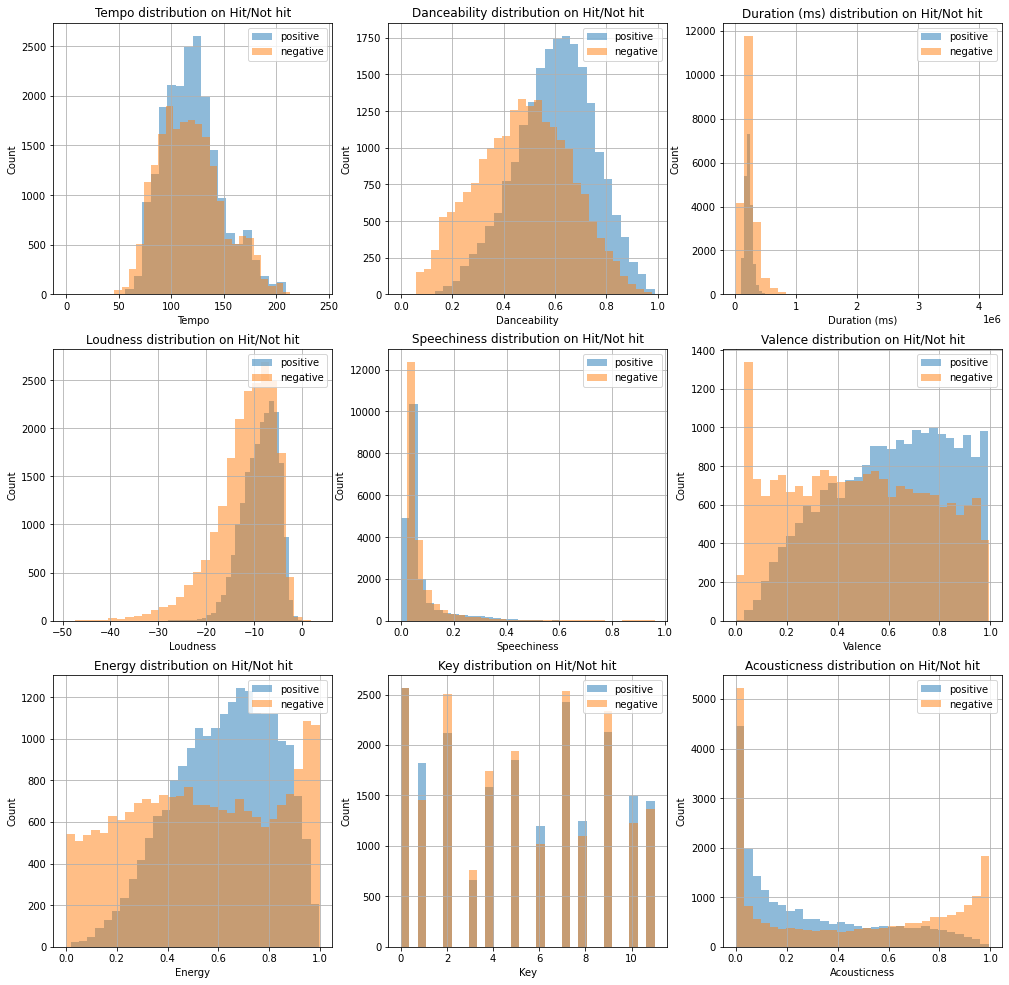

In [37]:
fig2 = plt.figure(figsize=(17,17))

pos = 331
Title = ['Tempo', 'Danceability', 'Duration (ms)', 'Loudness' , 'Speechiness', 'Valence', 'Energy', 'Key', 'Acousticness', 'Instrumentalness']
pos_plot = [pos_tempo, pos_dance, pos_duration, pos_loud, pos_speech, pos_valence, pos_energy, pos_key, pos_acousticness, pos_instrumentalness]
nev_plot = [nev_tempo, nev_dance, nev_duration, nev_loud, nev_speech, nev_valence, nev_energy, nev_key, nev_acousticness, nev_instrumentalness]
for i in range(9):
    ax3=fig2.add_subplot(pos)
    ax3.set_title(Title[i] + " distribution on Hit/Not hit")
    ax3.set_xlabel(Title[i])
    ax3.set_ylabel('Count')
    pos_plot[i].hist(alpha = 0.5, bins = 30, label = "positive")
    nev_plot[i].hist(alpha = 0.5, bins = 30, label = "negative")
    ax3.legend(loc = "upper right")

    pos += 1 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


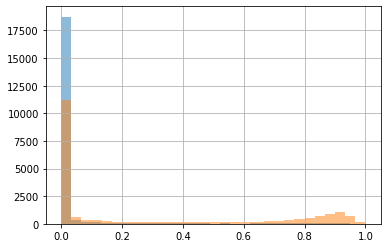

In [38]:
ax4=fig2.add_subplot(331)
ax4.set_title("Instrumentalness distribution on Hit/Not hit")
ax4.set_xlabel('Instrumentalness')
ax4.set_ylabel('Count')
pos_plot[9].hist(alpha = 0.5, bins = 30, label = "positive")
nev_plot[9].hist(alpha = 0.5, bins = 30, label = "negative")
ax4.legend(loc = "upper right")

Create a decision tree classifier

In [39]:
tree = DecisionTreeClassifier(min_samples_split=100)

In [40]:
features = ['danceability', 'loudness', 'valence', 'energy', 'instrumentalness', 'acousticness', 'key', 'speechiness', 'duration_ms']

In [41]:
train, test = train_test_split(df, train_size = 0.8, shuffle = True, random_state = 1)

X_train = train[features]
Y_train = train['target']

X_test = test[features]
Y_test = test['target']

dt = tree.fit(X_train, Y_train)

Calculate the accuracy score using decision tree


In [56]:
from sklearn.metrics import accuracy_score


y_pred = tree.predict(X_test)

score = accuracy_score(Y_test, y_pred) * 100
print("Accuracy score by decision tree : " + str(score))


Accuracy score by decision tree : 74.28849428362929


For this, we try 5 random Track and give it to model and see how it prediction on each song.


In [108]:
train, test = train_test_split(df, train_size = 0.8, shuffle = True, random_state = 1)

X_train = train[features]
Y_train = train['target']

X_test = test[features]
Y_test = test['target']

dt = tree.fit(X_train, Y_train)

y_pred = tree.predict(X_test)

print("Models predict if track is Hit/Not hit: ")
print(test['track'].head())
print('-----------------------')
for i in range(5):
    print("Track [" + str(i) + "] is a Hit (1)/ Not Hit(0)")
    print(y_pred[i])
    

score = accuracy_score(Y_test, y_pred) * 100
print("Accuracy score by decision tree : " + str(score))

Models predict if track is Hit/Not hit: 
9562     Oh, Babe, What Would You Say?
31082                   MacArthur Park
21176                    Give It To Me
10706                  Affair in Aruba
13063           A Change Is Gonna Come
Name: track, dtype: object
-----------------------
Track [0] is a Hit (1)/ Not Hit(0)
1
Track [1] is a Hit (1)/ Not Hit(0)
0
Track [2] is a Hit (1)/ Not Hit(0)
1
Track [3] is a Hit (1)/ Not Hit(0)
0
Track [4] is a Hit (1)/ Not Hit(0)
1
Accuracy score by decision tree : 74.28849428362929


Train Data and individual models


In [44]:
#training data

mlModels = {
    "                   Logistic Regression": LogisticRegression(),
    "                   K-Nearest Neighbors": KNeighborsClassifier(),
    "                         Decision Tree": DecisionTreeClassifier(),
    "Support Vector Machine (Linear Kernel)": LinearSVC(),
    "   Support Vector Machine (RBF Kernel)": SVC(),
    "                        Neural Network": MLPClassifier()
}


#training individual models
for name, model in mlModels.items():
    model.fit(x_train, y_train)
    print(name + " trained.")

#results

for name, model in mlModels.items():
    print(name + ": {:.2f}%".format(model.score(x_test, y_test) * 100))


                   Logistic Regression trained.
                   K-Nearest Neighbors trained.
                         Decision Tree trained.
Support Vector Machine (Linear Kernel) trained.
   Support Vector Machine (RBF Kernel) trained.
                        Neural Network trained.
                   Logistic Regression: 74.13%
                   K-Nearest Neighbors: 75.27%
                         Decision Tree: 72.94%
Support Vector Machine (Linear Kernel): 74.15%
   Support Vector Machine (RBF Kernel): 80.15%
                        Neural Network: 80.15%


After determining the score, we can see that SVM for RBF kernel and Neural Network are the most precise algs
therefore, we will proceed using those

In [110]:
svcModel = SVC()
NNmodel = MLPClassifier()

svcModel.fit(x_train, y_train)
NNmodel.fit(x_train, y_train)

y1_pred = svcModel.predict(x_test)
y2_pred = NNmodel.predict(x_test)
print(y1_pred)
print(y2_pred)
#calculate mse of predictions vs actual

mseSVC = round(metrics.mean_squared_error(y_test, y1_pred), 3)
mseNN = round(metrics.mean_squared_error(y_test, y2_pred), 3)

print("Calculate mse of prediction vs actual")
print(mseSVC)
#y_test.to_numpy()
#print(calculate_error(y1_pred,y_test))

[1 0 1 ... 1 0 0]
[1 0 1 ... 1 0 1]
Calculate mse of prediction vs actual
0.198


Method for generating songs for prediction


In [46]:
def make_song(danceability = x_train["danceability"].mean(),
                energy = x_train["energy"].mean(),
                key = x_train["key"].mean(),
                loudness = x_train["loudness"].mean(),
                mode = x_train["mode"].mean(),
                speechiness = x_train["speechiness"].mean(),
                acousticness = x_train["acousticness"].mean(),
                instrumentalness = x_train["instrumentalness"].mean(),
                liveness = x_train["liveness"].mean(),
                valence = x_train["valence"].mean(),
                tempo = x_train["tempo"].mean(),
                duration_ms = x_train["duration_ms"].mean(),
                time_signature = x_train["time_signature"].mean(),
                chorus_hit = x_train["chorus_hit"].mean(),
                sections = x_train["sections"].mean()):
                decade = 2010
                return pd.DataFrame({   "danceability": danceability,
                                        "energy": energy,
                                        "key": key,
                                        "loudness": loudness,
                                        "mode": mode,
                                        "speechiness": speechiness,
                                        "acousticness": acousticness,
                                        "instrumentalness": instrumentalness,
                                        "liveness": liveness,
                                        "valence": valence,
                                        "tempo": tempo,
                                        "duration_ms": duration_ms,
                                        "time_signature": time_signature,
                                        "chorus_hit": chorus_hit,
                                        "sections": sections,
                                        "decade": decade
                }, index = [0])

print(svcModel.predict(make_song(acousticness= 1, valence = 1, liveness = 1)))

[0]


after determining the score, we can see that SVM for RBF kernel and Neural Network are the most precise algs
therefore, we will procede using those

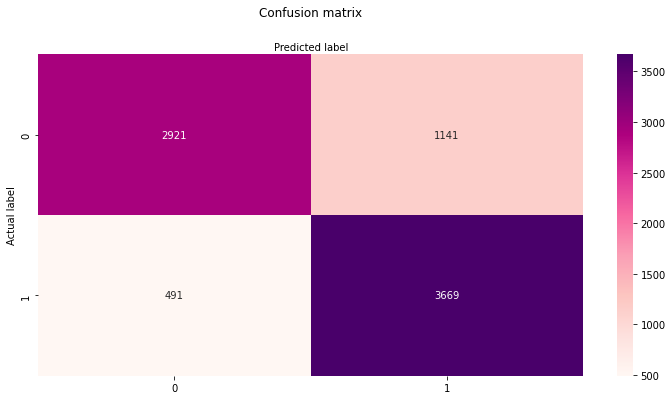

In [113]:
svcModel = SVC()
NNmodel = MLPClassifier()

svcModel.fit(x_train, y_train)
NNmodel.fit(x_train, y_train)

y1_pred = svcModel.predict(x_test)
y2_pred = NNmodel.predict(x_test)

#calculate a confusion matrix

cnf_matrix = metrics.confusion_matrix(y_test, y1_pred)
cnf2_matrix = metrics.confusion_matrix(y_test, y2_pred)

#creating the map
mpl.rcParams['figure.figsize']=(10,5)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="RdPu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

here we will test multiple samples of the df ie. different songs and see which ones are hits and if they fit in our ranges

In [114]:
#the average song is a flop "0"
print(svcModel.predict(make_song()))

#now lets look at some important features of the dataset to inquire what to predict
df = pd.DataFrame(x_train)

#here we will test multiple samples of the df ie. different songs and see which ones are hits and if they fit in our ranges
pd.set_option('display.max_columns', None)
for i in range(0,10):
    sample = df.sample()
    
    print(sample)
    print(svcModel.predict(sample))

for i in range(0,10):
    sample = df.sample()
    print(sample)
    print(NNmodel.predict(sample))

[0]
       danceability    energy       key  loudness      mode  speechiness  \
12386     -0.913875 -1.258774 -1.475051 -1.035121  0.665185    -0.369154   

       acousticness  instrumentalness  liveness   valence     tempo  \
12386     -0.683833           2.37116 -0.494368 -1.857941 -0.044955   

       duration_ms  time_signature  chorus_hit  sections    decade  
12386    -0.446643       -2.110933   -1.325761 -0.717444 -0.731163  
[0]
       danceability    energy       key  loudness      mode  speechiness  \
27828      -1.73641 -1.064966  1.638509  0.238059 -1.503342    -0.497627   

       acousticness  instrumentalness  liveness  valence     tempo  \
27828      1.756085         -0.508812  1.054145 -1.42583 -0.869216   

       duration_ms  time_signature  chorus_hit  sections    decade  
27828    -0.271456        0.253531   -0.546783 -0.303854 -1.302975  
[0]
       danceability    energy      key  loudness      mode  speechiness  \
15523      0.015702  1.426859 -0.90895  1.46973